In [0]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

from collections import defaultdict, Counter
from graphframes import GraphFrame
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.sql import DataFrame, Window
from pyspark.sql import functions as F
from pyspark.sql.functions import lit, col, count, when, monotonically_increasing_id, sum as spark_sum, mean as spark_mean
from pyspark.sql.types import IntegerType, DoubleType
from statistics import median
from typing import List, Dict


## Read in the Data

In [0]:
# Train Set
otpw_2015 = spark.read.parquet(f"dbfs:/mnt/mids-w261/datasets_final_project/parquet_airlines_data/2015.parquet/", inferSchema="true").drop('DIV5_TAIL_NUM')
otpw_2016 = spark.read.parquet(f"dbfs:/mnt/mids-w261/datasets_final_project/parquet_airlines_data/2016.parquet/", inferSchema="true")
otpw_2017 = spark.read.parquet(f"dbfs:/mnt/mids-w261/datasets_final_project/parquet_airlines_data/2017.parquet/", inferSchema="true")
otpw_2018 = spark.read.parquet(f"dbfs:/mnt/mids-w261/datasets_final_project/parquet_airlines_data/2018.parquet/", inferSchema="true")
otpw_train = otpw_2015.union(otpw_2016).union(otpw_2017).union(otpw_2018)

# Test Set
otpw_test = spark.read.parquet(f"dbfs:/mnt/mids-w261/datasets_final_project/parquet_airlines_data/2019.parquet/", inferSchema="true")

## Visualizations

In [0]:
def format_percent_and_count(pct, allvals):
    absolute = int(pct/100.*sum(allvals))
    return f'{pct:.1f}%\n({absolute})'

def plot_pie_chart(df, year):
    plt.figure(figsize=(8, 6))
    plt.pie(df['Count'], 
            labels=['On-Time', 'Delayed'], 
            autopct=lambda pct: format_percent_and_count(pct, df['Count']), 
            startangle=140)
    plt.title(f'Proportion of {year} Flights with Arrival Delay\n(15 Minutes or Greater)')
    plt.show()

   ARR_DEL15    Count
0        0.0  4650569
2        1.0  1063439


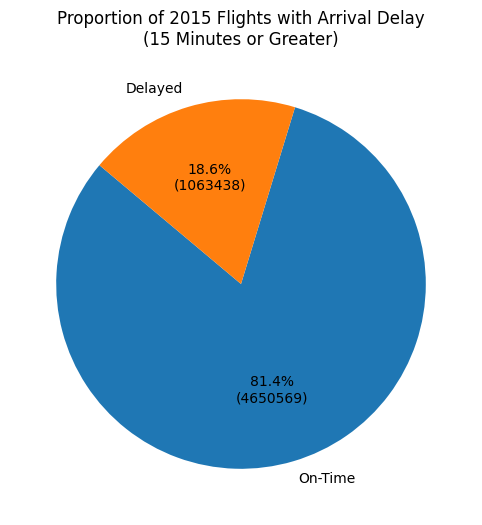

In [0]:
arrival_delay_counts_2015 = otpw_2015.select("ARR_DEL15").groupBy("ARR_DEL15").agg(count("*").alias("Count"))
arrival_delay_counts_2015 = arrival_delay_counts_2015.toPandas()
arrival_delay_counts_2015 = arrival_delay_counts_2015.drop(1)
print(arrival_delay_counts_2015.head(5))
plot_pie_chart(arrival_delay_counts_2015, 2015)

   ARR_DEL15    Count
0        0.0  4573906
2        1.0   964239


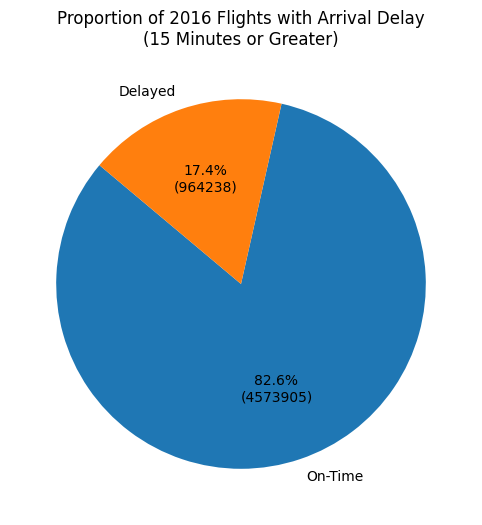

In [0]:
arrival_delay_counts_2016 = otpw_2016.select("ARR_DEL15").groupBy("ARR_DEL15").agg(count("*").alias("Count"))
arrival_delay_counts_2016 = arrival_delay_counts_2016.toPandas()
arrival_delay_counts_2016 = arrival_delay_counts_2016.drop(1)
print(arrival_delay_counts_2016.head(5))
plot_pie_chart(arrival_delay_counts_2016, 2016)

   ARR_DEL15    Count
0        0.0  4549936
2        1.0  1029474


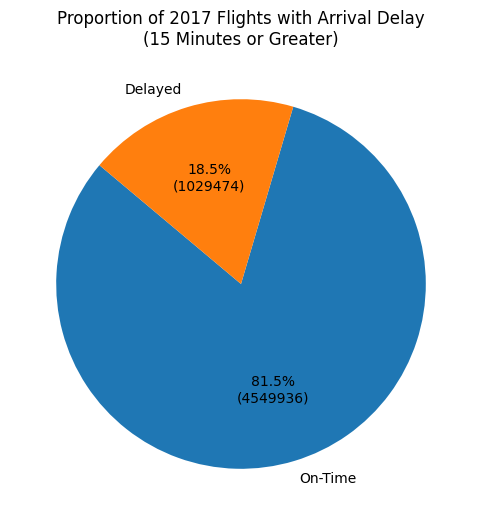

In [0]:
arrival_delay_counts_2017 = otpw_2017.select("ARR_DEL15").groupBy("ARR_DEL15").agg(count("*").alias("Count"))
arrival_delay_counts_2017 = arrival_delay_counts_2017.toPandas()
arrival_delay_counts_2017 = arrival_delay_counts_2017.drop(1)
print(arrival_delay_counts_2017.head(5))
plot_pie_chart(arrival_delay_counts_2017, 2017)

   ARR_DEL15    Count
0        0.0  5723696
2        1.0  1352710


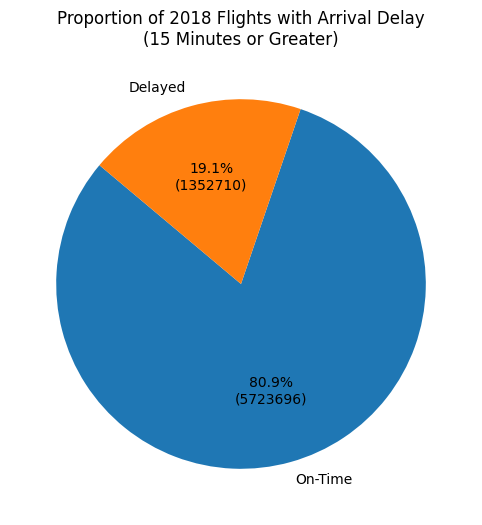

In [0]:
arrival_delay_counts_2018 = otpw_2018.select("ARR_DEL15").groupBy("ARR_DEL15").agg(count("*").alias("Count"))
arrival_delay_counts_2018 = arrival_delay_counts_2018.toPandas()
arrival_delay_counts_2018 = arrival_delay_counts_2018.drop(1)
print(arrival_delay_counts_2018.head(5))
plot_pie_chart(arrival_delay_counts_2018, 2018)

## Data Preprocessing 

#### Missing Values Analysis

In [0]:
def missing_values_analysis(df):
    """
    Perform missing values analysis on the given DataFrame and print the summary.

    Parameters:
    df (pyspark.sql.DataFrame): The input DataFrame.

    Returns:
    pandas.DataFrame: A summary DataFrame of missing values analysis.
    """
    # Calculate the number of missing values for each column
    missing_values_count = df.select(
        [spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df.columns]
    ).toPandas().T

    # Calculate the percentage of missing values for each column
    total_rows = df.count()
    missing_values_percentage = (missing_values_count / total_rows) * 100

    # Combine the counts and percentages into a single DataFrame
    missing_values_summary = pd.concat([missing_values_count, missing_values_percentage], axis=1)
    missing_values_summary.columns = ["Missing Values Count", "Percentage of Missing Values"]

    # Reset the index to make the column names a separate column
    missing_values_summary = missing_values_summary.reset_index()
    missing_values_summary = missing_values_summary.rename(columns={'index': 'Column Name'})

    # Sort the DataFrame by 'Percentage of Missing Values' in descending order
    missing_values_summary = missing_values_summary.sort_values(by="Percentage of Missing Values", ascending=False)

    # Calculate the number of columns with 100% missing values
    columns_with_all_missing = missing_values_summary[missing_values_summary["Percentage of Missing Values"] == 100].shape[0]

    # Calculate the total number of columns
    total_columns = missing_values_summary.shape[0]

    # Calculate the percentage of columns with 100% missing values
    percentage_columns_with_all_missing = (columns_with_all_missing / total_columns) * 100

    # Display the results
    print(f"Total number of columns with 100% missing values: {columns_with_all_missing}")
    print(f"Total number of columns: {total_columns}")
    print(f"Percentage of columns with 100% missing values: {percentage_columns_with_all_missing:.2f}%")

    # Calculate the number of columns with some missing values
    columns_with_some_missing = missing_values_summary[
        (missing_values_summary["Percentage of Missing Values"] > 0) &
        (missing_values_summary["Percentage of Missing Values"] != 100)
    ].shape[0]

    # Calculate the percentage of columns with some missing values
    percentage_columns_with_some_missing = (columns_with_some_missing / total_columns) * 100

    # Display the results
    print(f"Total number of columns with some missing values: {columns_with_some_missing}")
    print(f"Percentage of columns with some missing values: {percentage_columns_with_some_missing:.2f}%")

    return missing_values_summary

#### Handle Missing Values in Numerical Columns

In [0]:
def missing_value_computation_numeric_cols(df: DataFrame) -> (DataFrame, dict):
    # Define columns to cast to double
    columns_to_cast = [
        'CRS_DEP_TIME',
        'CRS_ARR_TIME',
        'CRS_ELAPSED_TIME',
        'DISTANCE',
        'ELEVATION',
        'HourlyAltimeterSetting',
        'HourlyDewPointTemperature',
        'HourlyDryBulbTemperature',
        'HourlyPrecipitation',
        'HourlyPressureChange',
        # 'HourlyPressureTendency', # handle by mode
        'HourlyRelativeHumidity',
        'HourlySkyConditions',
        'HourlySeaLevelPressure',
        'HourlyStationPressure',
        'HourlyVisibility',
        'HourlyWetBulbTemperature',
        # 'HourlyWindDirection', # handle with placeholder
        'HourlyWindSpeed',
        'BackupDistance'
    ]
    
    # Initialize a dictionary to store mean values for each column
    mean_values_dict = {}

    # Handle non-numeric values and cast specified columns to double
    for col_name in columns_to_cast:
        df = df.withColumn(col_name, F.when(F.col(col_name).rlike("^[0-9.]+$"), F.col(col_name)).otherwise(None))
        df = df.withColumn(col_name, F.col(col_name).cast("double"))

    # Impute missing values with the mean for the specified columns
    for col_name in columns_to_cast:
        mean_value = df.select(F.mean(F.col(col_name))).collect()[0][0]
        mean_values_dict[col_name] = mean_value
        df = df.na.fill({col_name: mean_value})

    # Handle HourlyPressureTendency by mode
    mode_pressure_tendency = (
        df.filter(F.col('HourlyPressureTendency').isNotNull())
        .groupBy('HourlyPressureTendency')
        .count()
        .orderBy(F.desc("count"))
        .first()[0]
    )
    df = df.na.fill({'HourlyPressureTendency': mode_pressure_tendency})
    df = df.withColumn('HourlyPressureTendency', F.col('HourlyPressureTendency').cast(IntegerType()))

    # Convert numerical wind direction to integers and handle non-numeric values
    df = df.withColumn("HourlyWindDirection", 
                    F.when(F.col("HourlyWindDirection") == "VRB", -1)
                        .otherwise(F.col("HourlyWindDirection").cast(IntegerType())))

    # Fill null values for wind direction with a placeholder, e.g., -999
    df = df.na.fill({"HourlyWindDirection": -999})

    return df, mean_values_dict

#### Handle Missing Values in Categorical Columns

In [0]:
def missing_value_computation_non_numeric_cols(df: DataFrame) -> DataFrame:
    # Impute missing values in WindEquipmentChangeDate with a catchall value (1900-01-01)
    df = df.na.fill({'WindEquipmentChangeDate': '1900-01-01'})

    # Impute TAIL_NUM with a placeholder
    df = df.na.fill({'TAIL_NUM': 'Unknown'})

    # Impute REM with a placeholder (mode not found in the initial code, so using 'Unknown')
    df = df.na.fill({'REM': 'Unknown'})

    return df

#### Additional Missing Values Preprocessing

In [0]:
def remove_gt_80pct_features(df: DataFrame, missing_values_summary: DataFrame) -> DataFrame:
    """
    Remove columns with 80% or more missing values.    Parameters:    df (DataFrame): The input DataFrame to clean.    missing_values_summary (DataFrame): DataFrame summarizing the missing values in the columns.
    """
    # Drop columns with 80% or more missing values
    columns_with_gt_80pct_missing_names = missing_values_summary[missing_values_summary["Percentage of Missing Values"] >= 80]["Column Name"].tolist()
    df = df.drop(*columns_with_gt_80pct_missing_names)

    return df

def drop_high_missing_cols(df: DataFrame) -> DataFrame:
    """
    Drop columns with more than 15% missing values and no predictive power.

    Parameters:
    df (DataFrame): The input DataFrame.

    Returns:
    DataFrame: The DataFrame with specified columns dropped.
    """
    columns_to_drop = [
        'CARRIER_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'SECURITY_DELAY', 'NAS_DELAY',
        'BackupElevation', 'BackupLatitude', 'BackupLongitude', 'BackupEquipment', 'BackupDistanceUnit',
        'BackupDirection', 'BackupElements', 'BackupName'
    ]

    df = df.drop(*columns_to_drop)
    
    return df

def drop_null_arr_delay_rows(df: DataFrame) -> DataFrame:
    """
    Drop rows with null values in the target var ARR_DELAY
    """

    # Drop rows where ARR_DELAY is null
    df = df.filter(col('ARR_DELAY').isNotNull())

    return df

## Feature Engineering

#### Wind Resistance

In [0]:
def process_relative_wind_angle(df: DataFrame) -> (DataFrame, dict):
    """
    Process the DataFrame to calculate the flight bearing, relative wind angle,
    and impute missing values for relative wind angle.
    
    Args:
        df (DataFrame): Input DataFrame with flight and wind data.

    Returns:
        (DataFrame, dict): A tuple containing the processed DataFrame and 
                           a dictionary with the mean value of relative wind angle.
    """

    def calculate_bearing(lat1, lon1, lat2, lon2):
        lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
        d_lon = lon2 - lon1
        x = math.sin(d_lon) * math.cos(lat2)
        y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1) * math.cos(lat2) * math.cos(d_lon))
        initial_bearing = math.atan2(x, y)
        initial_bearing = math.degrees(initial_bearing)
        compass_bearing = (initial_bearing + 360) % 360
        return compass_bearing

    # Cast latitude and longitude columns to double
    df = df.withColumn("origin_station_lat", F.col("origin_station_lat").cast(DoubleType()))
    df = df.withColumn("origin_station_lon", F.col("origin_station_lon").cast(DoubleType()))
    df = df.withColumn("dest_station_lat", F.col("dest_station_lat").cast(DoubleType()))
    df = df.withColumn("dest_station_lon", F.col("dest_station_lon").cast(DoubleType()))

    # Register the UDF
    calculate_bearing_udf = F.udf(calculate_bearing, DoubleType())

    # Add bearing column to the DataFrame
    df = df.withColumn("flight_bearing", calculate_bearing_udf(
        F.col("origin_station_lat"),
        F.col("origin_station_lon"),
        F.col("dest_station_lat"),
        F.col("dest_station_lon")
    ))

    # Create a feature for variable wind direction
    df = df.withColumn("variable_wind", F.when(F.col("HourlyWindDirection") == -1, 1).otherwise(0))

    # Replace "VRB" with null for HourlyWindDirection and cast to double
    df = df.withColumn("HourlyWindDirection", F.when(F.col("HourlyWindDirection") == -1, None).otherwise(F.col("HourlyWindDirection").cast(DoubleType())))

    # Calculate the relative wind angle
    df = df.withColumn("relative_wind_angle", F.abs(F.col("HourlyWindDirection") - F.col("flight_bearing")))
    df = df.withColumn("relative_wind_angle", F.when(F.col("relative_wind_angle") > 180, 360 - F.col("relative_wind_angle")).otherwise(F.col("relative_wind_angle")))

    # Impute the average for relative_wind_angle where it is null
    mean_relative_wind_angle = df.select(F.mean(F.col("relative_wind_angle"))).collect()[0][0]
    df = df.na.fill({"relative_wind_angle": mean_relative_wind_angle})

    # Store the mean in a dictionary for later use
    impute_dict = {"relative_wind_angle": mean_relative_wind_angle}

    return df, impute_dict

#### Holiday Indicator

In [0]:
def add_holiday_indicator(df: DataFrame, holiday_dates: list, date_column: str = "FL_DATE") -> DataFrame:
    """
    Adds a holiday indicator column to the DataFrame based on specified holiday dates.
    
    Args:
        df (DataFrame): The input DataFrame.
        holiday_dates (list): A list of dates (as strings) that are considered holidays.
        date_column (str): The name of the date column in the DataFrame. Default is "FL_DATE".
    
    Returns:
        DataFrame: The DataFrame with an additional 'is_holiday' column indicating holidays.
    """
    # Add the holiday indicator column
    df = df.withColumn("is_holiday", F.when(F.col(date_column).cast("string").isin(holiday_dates), 1).otherwise(0))
    return df

In [0]:
# Existing holidays for 2015
holiday_dates = ['2015-01-01', '2015-01-19', '2015-05-25', '2015-06-19', '2015-07-03', '2015-09-07', '2015-11-11', '2015-11-26', '2015-12-25']

# Append holidays for 2016
holiday_dates.extend([
    '2016-01-01', '2016-01-18', '2016-05-30', '2016-06-19', '2016-07-04',
    '2016-09-05', '2016-11-11', '2016-11-24', '2016-12-26'
])

# Append holidays for 2017
holiday_dates.extend([
    '2017-01-02', '2017-01-16', '2017-05-29', '2017-06-19', '2017-07-04',
    '2017-09-04', '2017-11-10', '2017-11-23', '2017-12-25'
])

# Append holidays for 2018
holiday_dates.extend([
    '2018-01-01', '2018-01-15', '2018-05-28', '2018-06-19', '2018-07-04',
    '2018-09-03', '2018-11-12', '2018-11-22', '2018-12-05', '2018-12-25'
])

# Append holidays for 2019
holiday_dates.extend([
    '2019-01-01', '2019-01-21', '2019-05-27', '2019-06-19', '2019-07-04',
    '2019-09-02', '2019-11-11', '2019-11-28', '2019-12-25'])


#### Weekend Indicator

In [0]:
def add_weekend_indicator(df: DataFrame, day_of_week_col: str = "DAY_OF_WEEK") -> DataFrame:
    """
    Add a weekend indicator column to the DataFrame.
    
    Parameters:
    df (DataFrame): Input DataFrame.
    day_of_week_col (str): The name of the column representing the day of the week (default is "DAY_OF_WEEK").
    
    Returns:
    DataFrame: DataFrame with an additional column "is_weekend" where 1 indicates weekend and 0 indicates weekday.
    """
    weekend_days = [6, 7]  # Assuming 6 = Saturday, 7 = Sunday
    df = df.withColumn("is_weekend", F.when(F.col(day_of_week_col).isin(weekend_days), 1).otherwise(0))
    return df


#### Days Since Equipment Change

In [0]:
def add_days_since_equipment_change(df: DataFrame, fl_date_col: str = "FL_DATE", equipment_change_date_col: str = "WindEquipmentChangeDate") -> DataFrame:
    """
    Ensure date columns are in the correct format and add a column calculating days since equipment change.

    Parameters:
    df (DataFrame): Input DataFrame.
    fl_date_col (str): The name of the flight date column (default is "FL_DATE").
    equipment_change_date_col (str): The name of the equipment change date column (default is "WindEquipmentChangeDate").

    Returns:
    DataFrame: DataFrame with an additional column "days_since_equipment_change" indicating the number of days since equipment change.
    """
    # Ensure the necessary date columns are in the correct format
    df = df.withColumn(fl_date_col, F.to_date(F.col(fl_date_col), "yyyy-MM-dd"))
    df = df.withColumn(equipment_change_date_col, F.to_date(F.col(equipment_change_date_col), "yyyy-MM-dd"))

    # Calculate days since equipment change
    df = df.withColumn("days_since_equipment_change", F.datediff(F.col(fl_date_col), F.col(equipment_change_date_col)))

    return df

#### Aircraft Flight Count

In [0]:
def add_aircraft_flight_count(df: DataFrame, tail_num_col: str = "TAIL_NUM", fl_date_col: str = "FL_DATE", window_days: int = 60) -> DataFrame:
    """
    Add a column for the frequency of flight counts for each aircraft (TAIL_NUM) over the last `window_days` days.

    Parameters:
    df (DataFrame): Input DataFrame.
    tail_num_col (str): The name of the aircraft tail number column (default is "TAIL_NUM").
    fl_date_col (str): The name of the flight date column (default is "FL_DATE").
    window_days (int): The window size in days to calculate flight count (default is 60 days).

    Returns:
    DataFrame: DataFrame with an additional column "aircraft_flight_count" indicating the flight count for each aircraft over the last `window_days` days.
    """
    # Define the window specification
    window_spec_flight = Window.partitionBy(tail_num_col).orderBy(fl_date_col).rowsBetween(-window_days, Window.currentRow)

    # Add the flight count column
    df = df.withColumn("aircraft_flight_count", F.count(tail_num_col).over(window_spec_flight))

    return df

#### Airline Performance

In [0]:
def add_airline_performance(df: DataFrame, carrier_col: str = "OP_UNIQUE_CARRIER", fl_date_col: str = "FL_DATE", delay_col: str = "ARR_DELAY", window_days: int = 7) -> DataFrame:
    """
    Add a column for the average arrival delay of flights conducted by each airline in the last `window_days` days.

    Parameters:
    df (DataFrame): Input DataFrame.
    carrier_col (str): The name of the airline carrier column (default is "OP_UNIQUE_CARRIER").
    fl_date_col (str): The name of the flight date column (default is "FL_DATE").
    delay_col (str): The name of the arrival delay column (default is "ARR_DELAY").
    window_days (int): The window size in days to calculate average delay (default is 7 days).

    Returns:
    DataFrame: DataFrame with an additional column "airline_performance" indicating the average arrival delay for each airline over the last `window_days` days.
    """
    # Define the window specification
    window_spec_airline = Window.partitionBy(carrier_col).orderBy(fl_date_col).rowsBetween(-window_days, Window.currentRow)

    # Add the airline performance column
    df = df.withColumn("airline_performance", F.avg(delay_col).over(window_spec_airline))

    return df

#### PageRank

In [0]:
def add_airport_pagerank(df: DataFrame)-> DataFrame:
    """
    Add a column for the PageRank score of each airport.
    """
    # Extract unique airport IDs from the flight data
    origin_airports = df.select(col("ORIGIN_AIRPORT_ID").alias("id"))
    dest_airports = df.select(col("DEST_AIRPORT_ID").alias("id"))
    vertices = origin_airports.union(dest_airports).distinct()
    edges = df.select(
        col("ORIGIN_AIRPORT_ID").alias("src"),
        col("DEST_AIRPORT_ID").alias("dst")
    )
    g = GraphFrame(vertices, edges)

    # Calculate PageRank
    pagerank_results = g.pageRank(resetProbability=0.15, maxIter=10)
    pagerank_scores = pagerank_results.vertices.select("id", "pagerank")

    df = df.join(pagerank_scores, df["ORIGIN_AIRPORT_ID"] == pagerank_scores["id"], "left")\
                    .drop("id")\
                    .withColumnRenamed("pagerank", "origin_airport_pagerank")
    df = df.join(pagerank_scores, df["DEST_AIRPORT_ID"] == pagerank_scores["id"], "left")\
                    .drop("id")\
                    .withColumnRenamed("pagerank", "dest_airport_pagerank")

## Model Building

#### Transform the Data

In [0]:
numerical_final = [
    'CRS_DEP_TIME', 
    'CRS_ARR_TIME', 
    'CRS_ELAPSED_TIME', 
    'DISTANCE', 
    'ELEVATION',
    'HourlyAltimeterSetting', 
    'HourlyDewPointTemperature', 
    'HourlyDryBulbTemperature',
    'HourlyPrecipitation', 
    'HourlyPressureChange', 
    'HourlyPressureTendency', 
    'HourlyRelativeHumidity',
    'HourlySeaLevelPressure', 
    'HourlyStationPressure', 
    'HourlyVisibility',
    'HourlyWetBulbTemperature', 
    'HourlyWindSpeed', 
    'relative_wind_angle', 
    'days_since_equipment_change', 
    'aircraft_flight_count', 
    'airline_performance',
    'origin_airport_pagerank', 
    'dest_airport_pagerank'
]

decided_categorical_final = [ 
    'variable_wind', 
    'is_holiday', 'is_weekend' 
]

In [0]:
# Function to save the median/mode values from numeric and non-numeric columns
def save_final_imputation_values(numeric_averages_dict, non_numeric_modes_dict):
    final_imputation_dict = {}

    # Calculate the median for numeric columns
    for col, values in numeric_averages_dict.items():
        final_imputation_dict[col] = median(values)

    # Calculate the mode for non-numeric columns
    for col, values in non_numeric_modes_dict.items():
        final_imputation_dict[col] = Counter(values).most_common(1)[0][0]

    return final_imputation_dict
    

# Initialize an empty DataFrame
final_df = None
test_df = None

# Initialize dictionaries to store all the average values for numeric columns
numeric_averages_dict = defaultdict(list)
non_numeric_modes_dict = defaultdict(list)


# Function to process each parquet part file
def process_part_file(file_path):
    # Load the parquet file
    df_otpw2 = spark.read.option("header", "true").csv(file_path)
    # df_otpw2 = spark.read.parquet(file_path)

    df_otpw2 = df_otpw2.orderBy("FL_DATE")
    df_otpw2 = remove_gt_80pct_features(df_otpw2, missing_values_analysis(df_otpw2))
    df_otpw2, numeric_missing_value_averages = missing_value_computation_numeric_cols(df_otpw2)
    # Store the numeric averages
    for col, value in numeric_missing_value_averages.items():
        numeric_averages_dict[col].append(value)

    df_otpw2, non_numeric_missing_value_averages = missing_value_computation_non_numeric_cols(df_otpw2)
    for col, value in non_numeric_missing_value_averages.items():
        non_numeric_modes_dict[col].append(value)

    df_otpw2 = drop_null_arr_delay_rows(df_otpw2)
    df_otpw2 = drop_high_missing_cols(df_otpw2)

    df_otpw2, wind_angle_impute_values = process_relative_wind_angle(df_otpw2)
    for col, value in wind_angle_impute_values.items():
        numeric_averages_dict[col].append(value)

    df_otpw2 = add_holiday_indicator(df_otpw2, holiday_dates)
    df_otpw2 = add_weekend_indicator(df_otpw2)
    df_otpw2 = add_days_since_equipment_change(df_otpw2)
    df_otpw2 = add_aircraft_flight_count(df_otpw2)
    df_otpw2 = add_airline_performance(df_otpw2)

    # Cast ARR_DEL15 as INTEGER
    
    df_otpw2 = df_otpw2.withColumn("ARR_DEL15", col("ARR_DEL15").cast("integer"))

    # Combine Final Feature Set for modeling
    df_otpw2 = df_otpw2.select(numerical_final + decided_categorical_final + ["ARR_DEL15"])

    # Index and encode categorical columns
    encoders = [OneHotEncoder(inputCol=column + "_index", outputCol=column + "_encoded", handleInvalid="keep") for column in decided_categorical_final]

    # Assemble numerical_final and encoded categorical features into a single feature vector
    assembler = VectorAssembler(
        inputCols=["features"] + [column + "_encoded" for column in decided_categorical_final],
        outputCol="final_features"
    )

    # Scale the feature vector
    scaler = StandardScaler(inputCol="final_features", outputCol="scaled_features")

    # Create the pipeline
    preprocessing_pipeline = Pipeline(stages=encoders + [assembler, scaler])

    # Fit and transform the data
    preprocessing_pipeline_model = preprocessing_pipeline.fit(oversampled_df)
    df_transformed = preprocessing_pipeline_model.transform(oversampled_df).cache()

    # Ensure row_num is a unique increasing identifier
    df_transformed = df_transformed.withColumn("row_num", F.row_number().over(Window.orderBy(F.monotonically_increasing_id()))).select("scaled_features", "label", "row_num")

    return df_transformed

# Process the training data (2015-2018)
years = list(range(2015, 2019))

base_path = f"dbfs:/mnt/mids-w261/OTPW_60M/"
file_paths = dbutils.fs.ls(base_path)

for path_info in file_paths:
    part_file_path = path_info.path 

    # Skip files that contain the word 'SUCCESS' in their path
    if "SUCCESS" in part_file_path:
        continue

    # Skip files that contain the word 'started' in their path
    if "started" in part_file_path:
        continue

    # Skip files that contain the word 'committed' in their path
    if "committed" in part_file_path:
        continue

    print(part_file_path)
    # Process each part file
    transformed_df = process_part_file(part_file_path)

    # Append the transformed DataFrame to the final DataFrame
    if final_df is None:
        final_df = transformed_df
    else:
        final_df = final_df.union(transformed_df)
    
    # Unpersist to free memory
    transformed_df.unpersist()


# After looping through all parquet files, calculate the final imputation values
final_imputation_dict = save_final_imputation_values(numeric_averages_dict, non_numeric_modes_dict)

final_df.cache()  # Optionally cache the DataFrame

# Show the schema and count to verify
final_df.printSchema()
print(f"Total records: {final_df.count()}")  # Trigger the computation
print("Processing Training Set complete.")

In [0]:
# Process the test data for 2019
test_path = f"dbfs:/mnt/mids-w261/datasets_final_project/parquet_airlines_data/2019.parquet/"
file_paths = dbutils.fs.ls(test_path)

for path_info in file_paths:
    part_file_path = path_info.path   

    # Skip files that contain the word 'SUCCESS' in their path
    if "SUCCESS" in part_file_path:
        continue

    # Skip files that contain the word 'started' in their path
    if "started" in part_file_path:
        continue

    # Skip files that contain the word 'committed' in their path
    if "committed" in part_file_path:
        continue

        print(part_file_path)
    # Process each part file
    sub_test_df = process_part_file(part_file_path)

    # Append the transformed DataFrame to the test DataFrame
    if test_df is None:
        test_df = sub_test_df
    else:
        test_df = test_df.union(sub_test_df)
    
    # Unpersist to free memory
    sub_test_df.unpersist()

# Cache the test_df after processing
test_df.cache()

print("Processing Test Set complete.")

#### Time Series Cross-Validator

In [0]:
class TimeSeriesCrossValidator:
    def __init__(self, estimator, evaluator, numFolds, estimatorParamMaps=None):
 
        self.estimator = estimator
        self.evaluator = evaluator
        self.numFolds = numFolds
        self.estimatorParamMaps = estimatorParamMaps if estimatorParamMaps is not None else [{}] # Make estimatorParamMaps optional

    def split(self, dataset):
        folds = []
        n = dataset.count()
        foldSize = n // self.numFolds
        
        for i in range(self.numFolds):
            start = i * foldSize
            stop = start + foldSize if i < self.numFolds - 1 else n
            mid = int(0.8 * (stop - start)) + start

            print(f"Fold {i + 1}/{self.numFolds}: start={start}, mid={mid}, stop={stop}")  # Debug statement
            
            # Adjusted logic to include all rows before the start of the validation set
            training = dataset.filter((col("row_num") >= start) & (col("row_num") < mid))
            val = dataset.filter((col("row_num") >= mid) & (col("row_num") < stop))
            
            # print(f"Training set count: {training.count()}")  # Debug statement
            # print(f"Validation set count: {val.count()}")  # Debug statement

            folds.append((training, val))
        
        return folds
    
    def fit(self, dataset: DataFrame):
        "Overriding with custom fit function"
        folds = self.split(dataset)
        best_model = None
        best_metric = float('-inf')
        metrics = {"accuracy": [], "precision": [], "recall": [], "f1": []}
        
        for training, val in folds:
            for paramMap in self.estimatorParamMaps:
                model = self.estimator.fit(training, paramMap)
                predictions = model.transform(val)
                
                # Evaluate the predictions with all metrics
                accuracy = evaluator_accuracy.evaluate(predictions)
                precision = evaluator_precision.evaluate(predictions)
                recall = evaluator_recall.evaluate(predictions)
                f1 = evaluator_f1.evaluate(predictions)
                
                metrics["accuracy"].append(accuracy)
                metrics["precision"].append(precision)
                metrics["recall"].append(recall)
                metrics["f1"].append(f1)

                # Update the best model if the current one is better
                if f1 > best_metric:
                    best_metric = f1
                    best_model = model
        
        # Calculate the average metric across all folds
        avg_metrics = {metric: sum(values) / len(values) for metric, values in metrics.items()}
        self.avg_metrics = avg_metrics  # Store average metrics
        self.bestModel = best_model  # Store the best model
        
        return self

#### Model Evaluator

In [0]:
def evaluate_classification_model(predictions: DataFrame, label_col: str) -> Dict[str, float]:
    # Initialize evaluators
    accuracy_evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="accuracy")
    precision_evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="weightedPrecision")
    recall_evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="weightedRecall")
    f1_evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="f1")

    # Calculate metrics
    accuracy = accuracy_evaluator.evaluate(predictions)
    precision = precision_evaluator.evaluate(predictions)
    recall = recall_evaluator.evaluate(predictions)
    f1_score = f1_evaluator.evaluate(predictions)

    # Return metrics
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score
    }

# Create evaluators for each metric
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")


In [0]:
def spark_evaluate_on_test(model, test_df: DataFrame, label_col: str = "label") -> Dict[str, float]:
    # Make predictions on the test set
    predictions = model.transform(test_df)

    # Initialize evaluators
    evaluator_f1 = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="f1")
    evaluator_accuracy = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="accuracy")
    evaluator_precision = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="weightedPrecision")
    evaluator_recall = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="weightedRecall")

    # Evaluate the predictions
    f1_score = evaluator_f1.evaluate(predictions)
    accuracy = evaluator_accuracy.evaluate(predictions)
    precision = evaluator_precision.evaluate(predictions)
    recall = evaluator_recall.evaluate(predictions)

    # Print the metrics
    print(f"Model Accuracy: {accuracy}")
    print(f"Model Precision: {precision}")
    print(f"Model Recall: {recall}")
    print(f"Model F1 Score: {f1_score}")